# Part 2: Explore data


## Read raw data from the lakehouse

Read raw data from the **Files** section of the lakehouse. You uploaded this data in the previous notebook. Make sure you have attached the same lakehouse you used in Part 1 to this notebook before you run this code.

In [1]:
df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv("Files/churn/raw/churn.csv")
    .cache()
).toPandas()

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 3, Finished, Available, Finished)

### Display raw data

Explore the raw data with `display`, do some basic statistics and show chart views. You first need to import required libraries for data visualization such as `seaborn`, which is a Python data visualization library to provide a high-level interface for building visuals on DataFrames and arrays. Learn more about [`seaborn`](https://seaborn.pydata.org/). 

In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 4, Finished, Available, Finished)

In [3]:
display(df, summary=True)

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c25303d0-4897-4ee6-a00d-da923b27a708)

In [4]:
def clean_data(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop duplicate rows in columns: 'RowNumber', 'CustomerId'
    df.drop_duplicates(subset=['RowNumber', 'CustomerId'], inplace=True)
    # Drop columns: 'RowNumber', 'CustomerId', 'Surname'
    df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
    return df

df_clean = clean_data(df.copy())
df_clean.head()

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 6, Finished, Available, Finished)

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

## Explore the data

Display some summaries and visualizations of the cleaned data.

### Determine categorical, numerical, and target attributes

Use this code to determine categorical, numerical, and target attributes.

In [5]:
# Determine the dependent (target) attribute
dependent_variable_name = "Exited"
print(dependent_variable_name)
# Determine the categorical attributes
categorical_variables = [col for col in df_clean.columns if col in "O"
                        or df_clean[col].nunique() <=5
                        and col not in "Exited"]
print(categorical_variables)
# Determine the numerical attributes
numeric_variables = [col for col in df_clean.columns if df_clean[col].dtype != "object"
                        and df_clean[col].nunique() >5]
print(numeric_variables)

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 7, Finished, Available, Finished)

Exited
['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


### The five-number summary 

Show the five-number summary (the minimum score, first quartile, median, third quartile, the maximum score) for the numerical attributes, using box plots.

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 8, Finished, Available, Finished)

/tmp/ipykernel_6773/4236202361.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


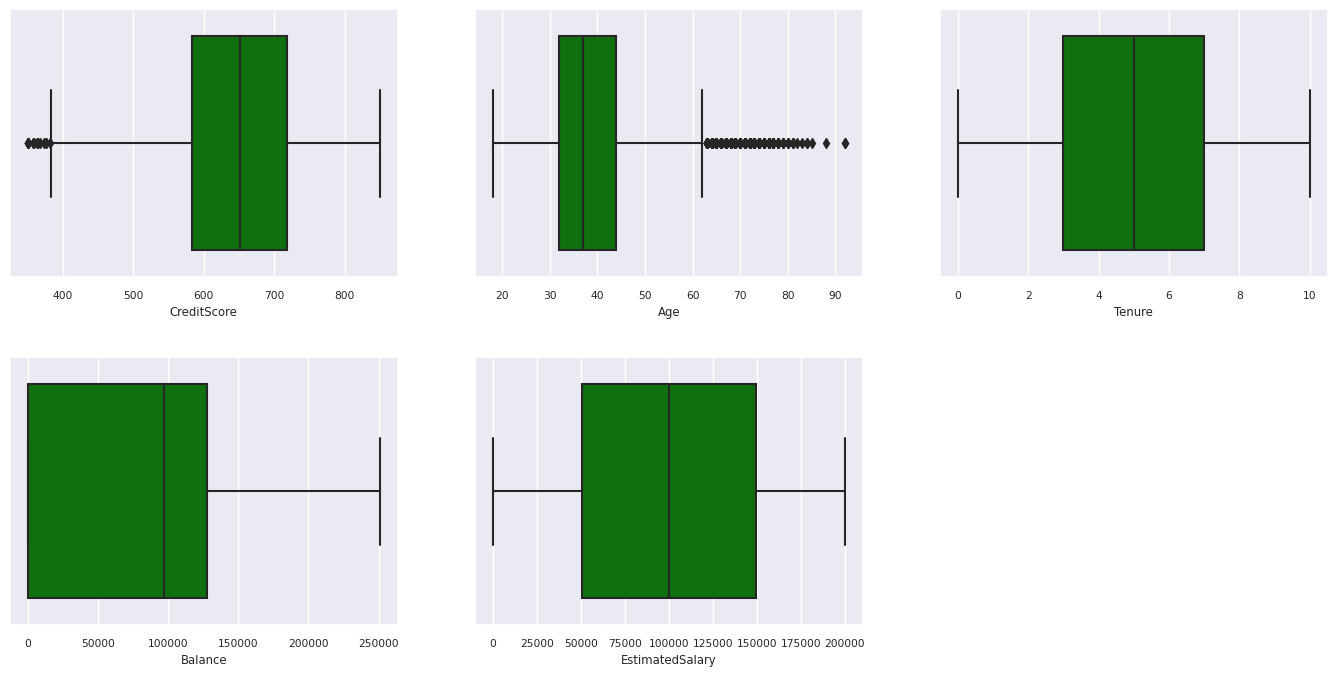

In [6]:
df_num_cols = df_clean[numeric_variables]
sns.set(font_scale = 0.7) 
fig, axes = plt.subplots(nrows = 2, ncols = 3, gridspec_kw =  dict(hspace=0.3), figsize = (17,8))
fig.tight_layout()
for ax,col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x = df_num_cols[col], color='green', ax = ax)
fig.delaxes(axes[1,2])


## Distribution of exited and nonexited customers 

Show the distribution of exited versus nonexited customers across the categorical attributes. 

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 9, Finished, Available, Finished)

0 Geography
1 Gender
2 HasCrCard
3 IsActiveMember
4 NumOfProducts
5 Tenure


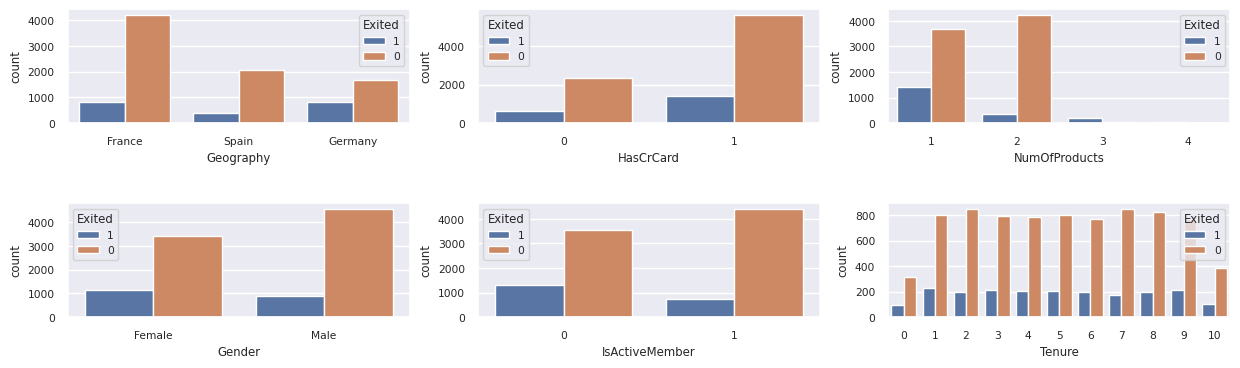

In [7]:
df_clean['Exited'] = df_clean['Exited'].astype(str)
attr_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
fig, axarr = plt.subplots(2, 3, figsize=(15, 4))
for ind, item in enumerate (attr_list):
    print(ind, item)
    sns.countplot(x = item, hue = 'Exited', data = df_clean, ax = axarr[ind%2][ind//2])
fig.subplots_adjust(hspace=0.7)
df_clean['Exited'] = df_clean['Exited'].astype(int)

### Distribution of numerical attributes

Show the frequency distribution of numerical attributes using histogram. 

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 10, Finished, Available, Finished)

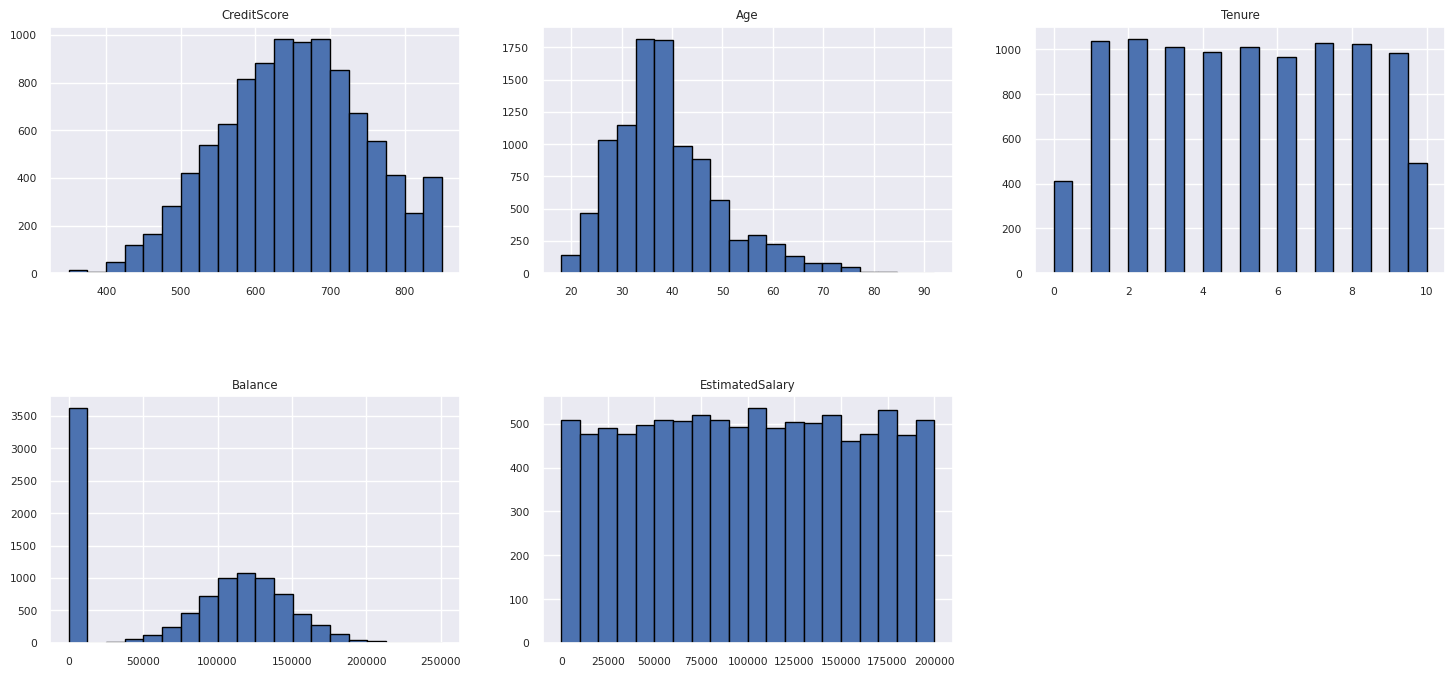

In [8]:
columns = df_num_cols.columns[: len(df_num_cols.columns)]
fig = plt.figure()
fig.set_size_inches(18, 8)
length = len(columns)
for i,j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2), 3, j+1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    df_num_cols[i].hist(bins = 20, edgecolor = 'black')
    plt.title(i)
plt.show()

## Perform feature engineering

Perform feature engineering to generate new attributes based on current attributes:

In [9]:
import pandas as pd

df_clean["NewTenure"] = df_clean["Tenure"]/df_clean["Age"]
df_clean["NewCreditsScore"] = pd.qcut(df_clean['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

def clean_data(df_clean):
    # One-hot encode columns: 'Geography', 'Gender'
    df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])
    return df_clean

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 11, Finished, Available, Finished)

In [10]:
df_clean_1 = clean_data(df_clean.copy())
df_clean_1.head()

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 12, Finished, Available, Finished)

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  NewTenure NewCreditsScore  \
0               1        101348.88       1   0.047619               3   
1               1        112542.58       0   0.024390               2   
2               0        113931.57       1   0.190476               1   
3               0         93826.63       0   0.025641               5   
4               1         79084.10       0   0.046512               6   

  NewAgeScore NewBalanceScore NewEstSalaryScore  Geography_France  \
0           6               1                 6              True   
1           6               3                 6             False   
2           6               5                 6              True   
3           5               1                 5              True   
4           6               4                 4             False   

   Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  
0              False            False           True        False  
1              False             True           True        False  
2              False            False           True        False  
3              False            False           True        False  
4              False             True           True        False

## Create a delta table for the cleaned data

You'll use this data in the next notebook of this series.

In [11]:
table_name = "df_clean"
# Create Spark DataFrame from pandas
sparkDF=spark.createDataFrame(df_clean_1) 
sparkDF.write.option("overwriteSchema", "true").mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 56761607-132f-451f-9a2e-910700cfb596, 13, Finished, Available, Finished)

Spark dataframe saved to delta table: df_clean
